In [0]:
import torch 
from torch import nn , optim 
from torch.utils.data import (Dataset,DataLoader,TensorDataset)

import tqdm 
from torchvision.datasets import ImageFolder 
from torchvision import transforms 
from torchvision.utils import save_image

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
img_data = ImageFolder( '/content/drive/My Drive/Ironman/',transform=transforms.Compose([
                                                    transforms.Resize(80),
                                                    transforms.CenterCrop(64),
                                                    transforms.ToTensor()
]))

###  ↑　　注意点は　path以下のフォルダにjpgフォルダを作りその中に画像を入れること
batch_size = 64 
img_loader = DataLoader(img_data,batch_size=batch_size,shuffle=True) 

潜在特徴ベクトルzを100次元にする　　

In [0]:
nz = 100 
ngf = 32 


class GNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.main = nn.Sequential(
        nn.ConvTranspose2d(nz, ngf * 8 , 4 , 1 , 0, bias = False),

        nn.BatchNorm2d(ngf * 8),
        nn.ReLU(inplace = True),
        nn.ConvTranspose2d(ngf * 8, ngf*4 , 4, 2, 1 , bias=False),
        
        nn.BatchNorm2d(ngf * 4),
        nn.ReLU(inplace = True),
        nn.ConvTranspose2d(ngf * 4, ngf*2 , 4, 2, 1 , bias=False),

        nn.BatchNorm2d(ngf * 2),
        nn.ReLU(inplace = True),
        nn.ConvTranspose2d(ngf * 2, ngf , 4, 2, 1 , bias=False),

        nn.BatchNorm2d(ngf),
        nn.ReLU(inplace = True),
        nn.ConvTranspose2d(ngf, 3 , 4, 2, 1 , bias=False),

        nn.Tanh()
    )
  def forward(self, x):
    out = self.main(x)
    return out 
    

識別モデルの作成

In [0]:
ndf = 32

class DNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
        )

    def forward(self, x):
        out = self.main(x)
        return out.squeeze()

In [0]:
d = DNet().to("cuda:0")
g = GNet().to("cuda:0")

# Adamのパラメータは元論文の提案値
opt_d = optim.Adam(d.parameters(),
    lr=0.0002, betas=(0.5, 0.999))
opt_g = optim.Adam(g.parameters(),
    lr=0.0002, betas=(0.5, 0.999))

# クロスエントロピーを計算するための補助変数など
ones = torch.ones(batch_size).to("cuda:0")
zeros = torch.zeros(batch_size).to("cuda:0")
loss_f = nn.BCEWithLogitsLoss()

# モニタリング用のz
fixed_z = torch.randn(batch_size, nz, 1, 1).to("cuda:0")

訓練関数の定義

In [0]:
from statistics import mean

def train_dcgan(g, d, opt_g, opt_d, loader):
    # 生成モデル、識別モデルの目的関数の追跡用の配列
    log_loss_g = []
    log_loss_d = []
    for real_img, _ in tqdm.tqdm(loader):
        batch_len = len(real_img)
        
         # 実際の画像をGPUにコピー
        real_img = real_img.to("cuda:0")
        
         # 偽画像を乱数と生成モデルから作る
        z = torch.randn(batch_len, nz, 1, 1).to("cuda:0")
        fake_img = g(z)
        
        # 後で使用するので偽画像の値のみ取り出しておく
        fake_img_tensor = fake_img.detach()
        
        # 偽画像に対する生成モデルの評価関数を計算する
        out = d(fake_img)
        loss_g = loss_f(out, ones[: batch_len])
        log_loss_g.append(loss_g.item())
        
        # 計算グラフが生成モデルと識別モデルの両方に
        # 依存しているので両者とも勾配をクリアしてから
        # 微分の計算とパラメータ更新を行う
        d.zero_grad(), g.zero_grad()
        loss_g.backward()
        opt_g.step()

        # 実際の画像に対する識別モデルの評価関数を計算
        real_out = d(real_img)
        loss_d_real = loss_f(real_out, ones[: batch_len])
        
        # PyTorchでは同じTensorを含んだ計算グラフに対して
        # 2回backwardを行うことができないので保存してあった
        # Tensorを使用して無駄な計算を省く
        fake_img = fake_img_tensor
        
        # 偽画像に対する識別モデルの評価関数の計算
        fake_out = d(fake_img_tensor)
        loss_d_fake = loss_f(fake_out, zeros[: batch_len])
        
        # 実偽の評価関数の合計値
        loss_d = loss_d_real + loss_d_fake
        log_loss_d.append(loss_d.item())
        
        # 識別モデルの微分計算とパラメータ更新
        d.zero_grad(), g.zero_grad()
        loss_d.backward()
        opt_d.step()
        
    return mean(log_loss_g), mean(log_loss_d)

In [0]:
for epoch in range(300):
  train_dcgan(g,d,opt_g,opt_d,img_loader)
  #10回ごとに学習を記録
  if epoch % 10 == 0:
    torch.save(
        g.state_dict(),'/content/drive/My Drive/Ironman/g_{:03d}.prm'.format(epoch),
        pickle_protocol = 4
    )
    torch.save(
        d.state_dict(),'/content/drive/My Drive/Ironman/g_{:03d}.prm'.format(epoch),
        pickle_protocol = 4
    )
    #モニタリング用のzから生成した画像を保存
    generated_img = g(fixed_z)
    save_image(generated_img,'/content/drive/My Drive/Ironman/{:03d}.jpg'.format(epoch))
    




  0%|          | 0/2 [00:00<?, ?it/s]


 50%|█████     | 1/2 [00:00<00:00,  3.88it/s]


100%|██████████| 2/2 [00:00<00:00,  4.25it/s]





  0%|          | 0/2 [00:00<?, ?it/s]


 50%|█████     | 1/2 [00:00<00:00,  4.09it/s]


100%|██████████| 2/2 [00:00<00:00,  4.42it/s]





  0%|          | 0/2 [00:00<?, ?it/s]


 50%|█████     | 1/2 [00:00<00:00,  3.97it/s]


100%|██████████| 2/2 [00:00<00:00,  4.22it/s]





  0%|          | 0/2 [00:00<?, ?it/s]


 50%|█████     | 1/2 [00:00<00:00,  3.69it/s]


100%|██████████| 2/2 [00:00<00:00,  4.01it/s]





  0%|          | 0/2 [00:00<?, ?it/s]


 50%|█████     | 1/2 [00:00<00:00,  3.97it/s]


100%|██████████| 2/2 [00:00<00:00,  4.26it/s]





  0%|          | 0/2 [00:00<?, ?it/s]


 50%|█████     | 1/2 [00:00<00:00,  3.70it/s]


100%|██████████| 2/2 [00:00<00:00,  4.06it/s]





  0%|          | 0/2 [00:00<?, ?it/s]


 50%|█████     | 1/2 [00:00<00:00,  3.54it/s]


100%|██████████| 2/2 [00:00<00:00,  3.91it/s]





  0%|          | 0/2 [00

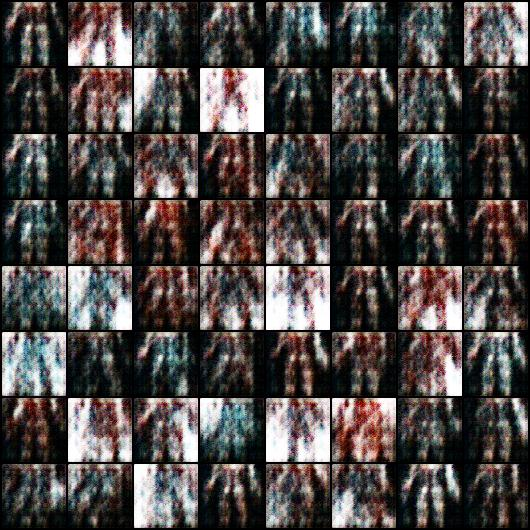

In [0]:
from IPython.display import Image,display_jpeg
display_jpeg(Image('/content/drive/My Drive/Ironman/000.jpg'))